In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [57]:

import torch
from torch import *
dataset_x = torch.load("/kaggle/input/combined-dataset-of-grayscale-cxr-images/dataset_x.pt")
dataset_y = torch.load("/kaggle/input/combined-dataset-of-grayscale-cxr-images/dataset_y.pt")

In [5]:
from sklearn.model_selection import train_test_split
xtr, xts, ytr, yts = train_test_split(dataset_x, dataset_y, test_size=0.2, shuffle=True, stratify=dataset_y)

In [15]:
xtr.size()

torch.Size([21782, 1, 224, 224])

In [79]:

%cd /kaggle/working
from IPython.display import FileLink
FileLink('final_x.pt')

/kaggle/working


/kaggle/working/final_x.pt

In [16]:
# Import the required libraries
import torch
from PIL import Image
import torchvision.transforms as T
import os
import cv2
from IPython.display import clear_output
# assign directory
dataset = []


In [39]:

directory = ['/kaggle/input/imbalanced-tuberculosis-and-pnuemonia-dataset/all_images/Tuberculosis']
cnt = 0
# iterate over files in
# that directory
ids = 0
for dirs in directory:
    cnt = 0
    for filename in os.listdir(dirs):
        f = os.path.join(dirs, filename)
        
        if os.path.isfile(f):
            trans_comp = T.Compose([
                         T.Resize([224,224]),
                         T.Grayscale(num_output_channels=1),
                         T.ToTensor()
                        ])
            im = Image.open(f)
             
            tensor = trans_comp(im)
            print(f'{cnt}-{tensor.shape}');
            clear_output();
            dataset.append([tensor,3])
            cnt+=1
        
        
             
     
    ids+=1

In [51]:
x = []
y = []

for i,j in dataset:
    x.append(i)
    y.append(j)


In [59]:
dataset_x_2 = torch.stack(x)
dataset_y_2 = torch.tensor(y)

In [60]:
dataset_y_2

tensor([0, 0, 0,  ..., 3, 3, 3])

In [61]:
final_x = torch.cat((dataset_x,dataset_x_2))
final_y = torch.cat((dataset_y,dataset_y_2))

In [78]:
final_y.size()

torch.Size([40377])

In [72]:
torch.save(final_x, 'f_x.pt')

In [74]:
torch.save(final_y, '2_y.pt')

tensor([ 9450, 10192, 10275, 10460])


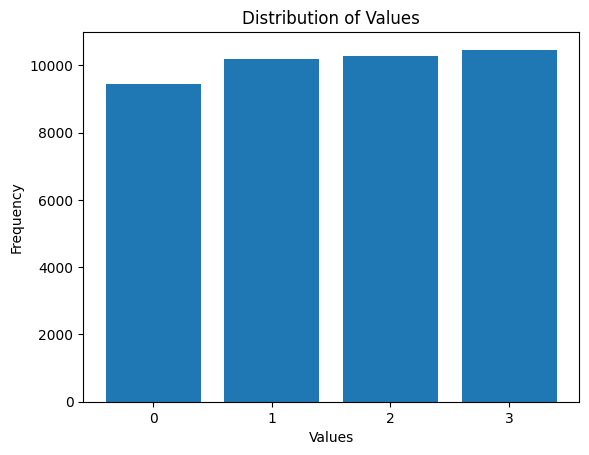

In [67]:
import torch
import matplotlib.pyplot as plt

# Replace this with your actual tensor
tensor_data = final_y.int()
tensor_data = tensor_data[(tensor_data >= 0) & (tensor_data <= 3)]

# Count the occurrences of each value
value_counts = torch.bincount(tensor_data)
print(value_counts)
# Plotting the bar chart

plt.bar(arange(len(value_counts)), value_counts)
plt.xticks(arange(4))
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()


In [ ]:
import torch
from torch import *
my_dataset = torch.utils.data.TensorDataset(xtr,ytr) # create your datset
my_dataloader = torch.utils.data.DataLoader(my_dataset,batch_size=32,
                                          shuffle=True, num_workers=2)

my_dataset = torch.utils.data.TensorDataset(xts,yts) # create your datset
my_tdataloader = torch.utils.data.DataLoader(my_dataset,batch_size=32)

# model

In [ ]:
import os
import time
from tempfile import TemporaryDirectory

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 



import timm

# from timm
pretrained_model_name = 'densenet201'
model = timm.create_model(pretrained_model_name, pretrained=True)

num_channels = 1  # for grayscale images, but it could be any number
# Extract the first conv layer's parameters
num_filters = model.features.conv0.out_channels
kernel_size = model.features.conv0.kernel_size
stride = model.features.conv0.stride
padding = model.features.conv0.padding
conv1 = torch.nn.Conv2d(num_channels, num_filters, kernel_size=kernel_size, stride=stride, padding=padding)
original_weights = model.features.conv0.weight.data.mean(dim=1, keepdim=True)
conv1.weight.data = original_weights.repeat(1, num_channels, 1, 1)
model.features.conv0 = conv1
model_ft = model

# Freeze only the convolutional layers of the pre-trained model
for param in model_ft.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False



# Modify the model head for fine-tuning
num_features = 2048

# Additional linear layer and dropout layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, 4)    # Final prediction fc layer
)

model_ft = torch.nn.DataParallel(model_ft, device_ids = [0,1]).to(device)
#model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



batch_size=32
num_epochs=30
val_size = len(my_tdataloader)
train_size = len(my_dataloader) 

losses = [] 
accuracies = [] 
val_losses = [] 
val_accuracies = [] 
# Train the model 

x = range(0,num_epochs)
for epoch in x: 
	for i, (images, labels) in enumerate(my_dataloader): 
		# Forward pass 
		images=images.to(device) 
		labels=labels.type(torch.LongTensor).to(device) 
		outputs = model(images) 
		loss = criterion(outputs, labels) 
		
		# Backward pass and optimization 
		optimizer_ft.zero_grad() 
		loss.backward() 
		optimizer_ft.step() 

		_, predicted = torch.max(outputs.data, 1) 
	acc = (predicted == labels).sum().item() / labels.size(0) 
	accuracies.append(acc) 
	losses.append(loss.item()) 

	# Evaluate the model on the validation set	
	print('Epoch [{}/{}],Loss:{:.4f},Accuracy:{:.2f}'.format( 
		epoch+1, num_epochs, loss.item(),acc))







# Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []  

# iterate over test data
for inputs, labels in my_tdataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('COVID','Normal','Pneumonia','Bacterial infection')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
classification_report(y_true, y_pred)